In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pycaret.classification import *
import mlflow
import mlflow.sklearn

In [2]:
data = pd.read_csv("02_medical_records.csv")

### Exploratory Data Analysis

In [3]:
data.head()

,age,gender,chest_pain,resting_BP,cholesterol,fasting_BS,resting_ECG,max_HR,exercise_angina,old_peak,ST_slope,cv_issue
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Get summary statistics of numerical columns
print(data.describe().T)

             count        mean         std   min     25%    50%    75%    max
age          918.0   53.510893    9.432617  28.0   47.00   54.0   60.0   77.0
resting_BP   918.0  132.396514   18.514154   0.0  120.00  130.0  140.0  200.0
cholesterol  918.0  198.799564  109.384145   0.0  173.25  223.0  267.0  603.0
fasting_BS   918.0    0.233115    0.423046   0.0    0.00    0.0    0.0    1.0
max_HR       918.0  136.809368   25.460334  60.0  120.00  138.0  156.0  202.0
old_peak     918.0    0.887364    1.066570  -2.6    0.00    0.6    1.5    6.2
cv_issue     918.0    0.553377    0.497414   0.0    0.00    1.0    1.0    1.0


In [5]:
# Check data types and missing values
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              918 non-null    int64  
 1   gender           918 non-null    object 
 2   chest_pain       918 non-null    object 
 3   resting_BP       918 non-null    int64  
 4   cholesterol      918 non-null    int64  
 5   fasting_BS       918 non-null    int64  
 6   resting_ECG      918 non-null    object 
 7   max_HR           918 non-null    int64  
 8   exercise_angina  918 non-null    object 
 9   old_peak         918 non-null    float64
 10  ST_slope         918 non-null    object 
 11  cv_issue         918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


### Data Visualisation

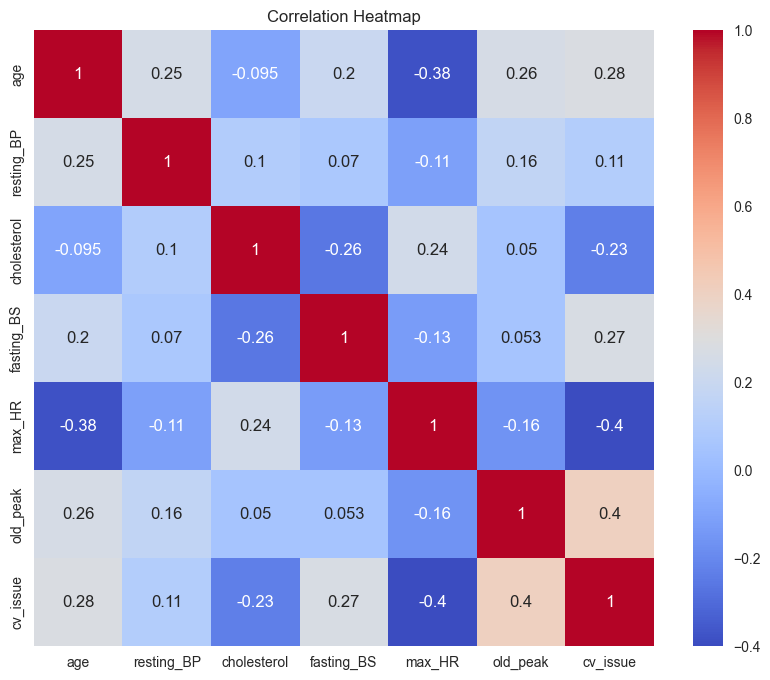

In [6]:
# Correlation heatmap
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

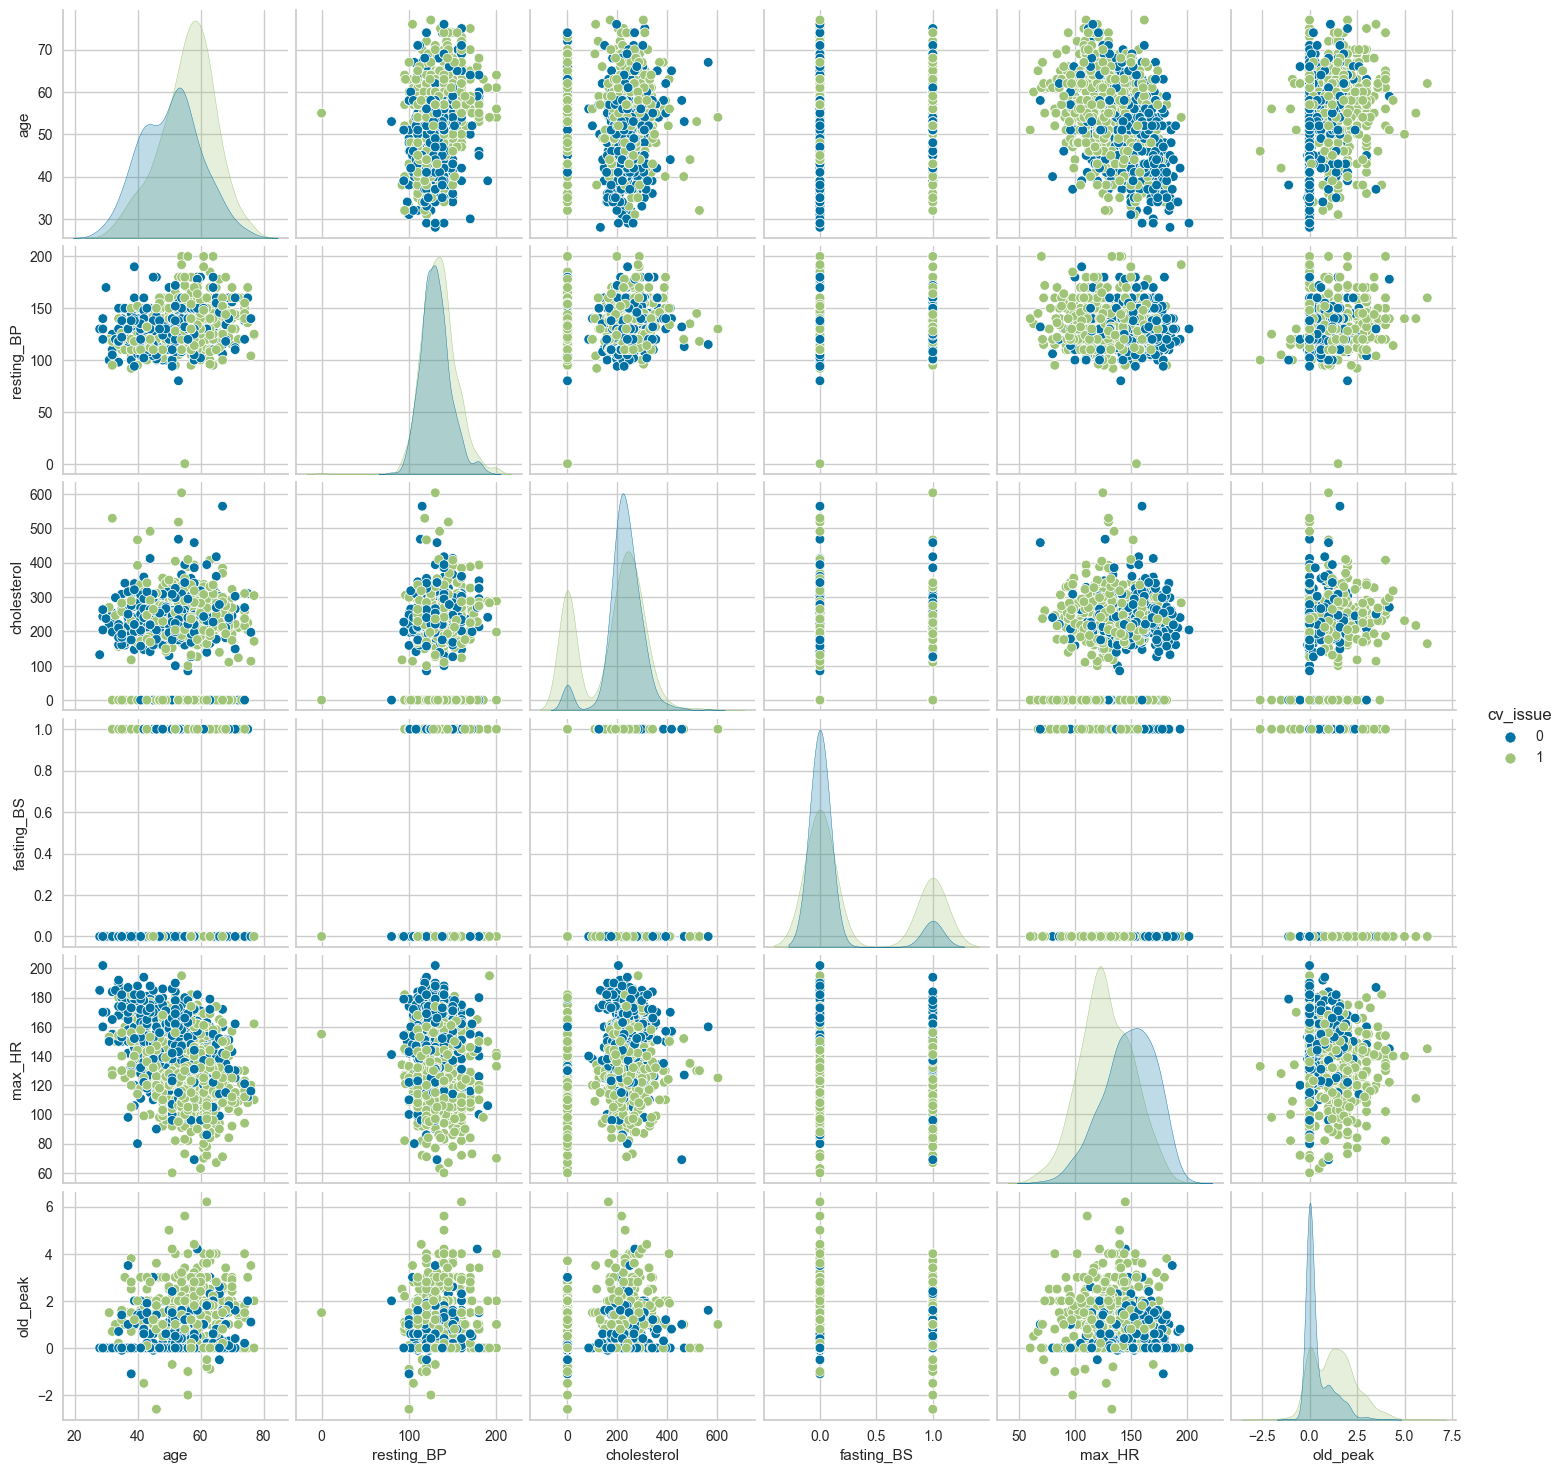

In [7]:
# Pairplot to visualize relationships between numeric variables
sns.pairplot(data, hue='cv_issue', diag_kind='kde')
plt.show()

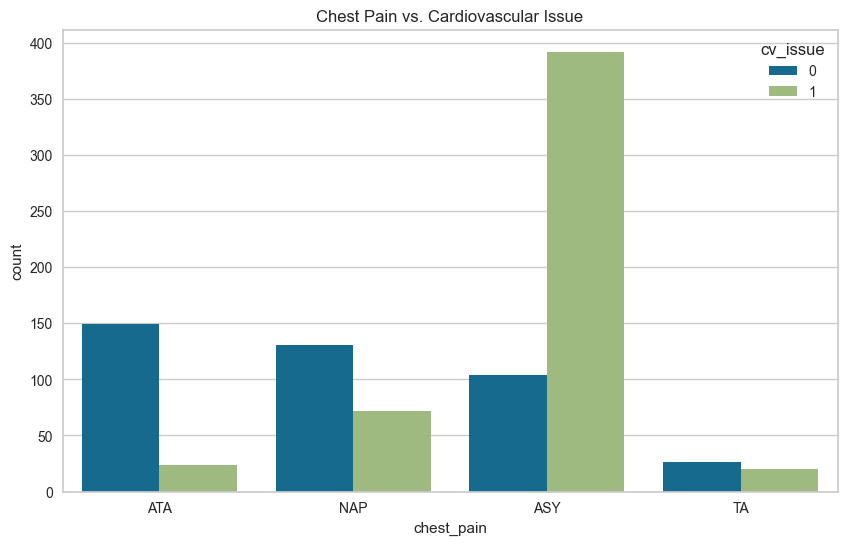

In [8]:
# Count plot for categorical variables
plt.figure(figsize=(10, 6))
sns.countplot(x='chest_pain', hue='cv_issue', data=data)
plt.title('Chest Pain vs. Cardiovascular Issue')
plt.show()

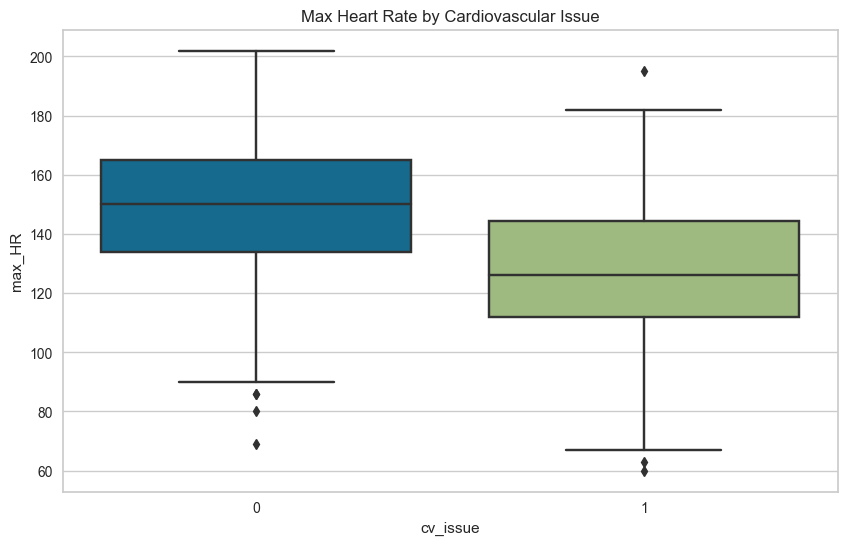

In [9]:
# Box plot for heart rate by cardiovascular issue
plt.figure(figsize=(10, 6))
sns.boxplot(x='cv_issue', y='max_HR', data=data)
plt.title('Max Heart Rate by Cardiovascular Issue')
plt.show()

### Task 2

In [10]:
# Specify the new experiment name for logging
experiment_name = 'heart_disease_prediction'

In [11]:
# Initialize PyCaret setup 
exp = setup(data=data,
            target='cv_issue',
            session_id=123,
            remove_multicollinearity=True,
            multicollinearity_threshold=0.95,
            normalize=True,  
            transformation=True,
            polynomial_features=True,
            log_experiment=True,  
            experiment_name=experiment_name)

,Description,Value
0,Session id,123
1,Target,cv_issue
2,Target type,Binary
3,Original data shape,"(918, 12)"
4,Transformed data shape,"(918, 133)"
5,Transformed train set shape,"(642, 133)"
6,Transformed test set shape,"(276, 133)"
7,Ordinal features,2
8,Numeric features,6
9,Categorical features,5


2023/08/19 23:06:55 INFO mlflow.tracking.fluent: Experiment with name 'heart_disease_prediction' does not exist. Creating a new experiment.


### Compare Different Models and Select the Best Ones

In [12]:
# Compare different models and select the best ones
best_models = compare_models(sort='AUC', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8817,0.9301,0.9098,0.8834,0.8953,0.7594,0.7624,1.7930
lightgbm,Light Gradient Boosting Machine,0.8692,0.9231,0.8955,0.8737,0.8837,0.7342,0.7358,1.5760
rf,Random Forest Classifier,0.8676,0.9219,0.8955,0.8712,0.8825,0.7309,0.7328,2.0130
gbc,Gradient Boosting Classifier,0.8614,0.9192,0.8790,0.8762,0.8758,0.7189,0.7225,1.7980
ada,Ada Boost Classifier,0.8489,0.9157,0.8589,0.8687,0.8623,0.6946,0.6976,1.6130
xgboost,Extreme Gradient Boosting,0.8490,0.9134,0.8789,0.8550,0.8659,0.6932,0.6954,1.4940
et,Extra Trees Classifier,0.8428,0.9094,0.8562,0.8609,0.8578,0.6819,0.6833,1.8990
lda,Linear Discriminant Analysis,0.8473,0.9078,0.8704,0.8587,0.8634,0.6904,0.6929,1.5040
knn,K Neighbors Classifier,0.8504,0.9067,0.8594,0.8740,0.8642,0.6976,0.7024,1.6680
lr,Logistic Regression,0.8395,0.8955,0.8706,0.8495,0.8575,0.6739,0.6794,4.6300


Processing:   0%|          | 0/71 [00:00<?, ?it/s]

In [13]:
# Ensembling the best models
ensemble_model = blend_models(estimator_list=best_models, method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8154,0.9253,0.8611,0.8158,0.8378,0.6239,0.6251
1,0.9077,0.9780,0.8889,0.9412,0.9143,0.8145,0.8160
2,0.8438,0.8798,0.8857,0.8378,0.8611,0.6829,0.6842
3,0.7812,0.8700,0.8857,0.7561,0.8158,0.5507,0.5612
4,0.8750,0.9182,0.9143,0.8649,0.8889,0.7463,0.7478
5,0.9062,0.9241,0.9143,0.9143,0.9143,0.8108,0.8108
6,0.8750,0.8995,0.8571,0.9091,0.8824,0.7493,0.7507
7,0.8906,0.9583,0.9444,0.8718,0.9067,0.7751,0.7787
8,0.9531,0.9683,0.9722,0.9459,0.9589,0.9044,0.9048


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Evaluation

In [14]:
# Analyze the performance of the ensemble model
evaluate_model(ensemble_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [15]:
# Create a new DataFrame without the "cv_issue" column
unseen_data = data.drop(columns=['cv_issue'])

# Generate predictions on the modified unseen data
predictions = predict_model(ensemble_model, data=unseen_data)

In [16]:
print(predictions)

     age gender chest_pain  resting_BP  cholesterol  fasting_BS resting_ECG  \
0     40      M        ATA         140          289           0      Normal   
1     49      F        NAP         160          180           0      Normal   
2     37      M        ATA         130          283           0          ST   
3     48      F        ASY         138          214           0      Normal   
4     54      M        NAP         150          195           0      Normal   
..   ...    ...        ...         ...          ...         ...         ...   
913   45      M         TA         110          264           0      Normal   
914   68      M        ASY         144          193           1      Normal   
915   57      M        ASY         130          131           0      Normal   
916   57      F        ATA         130          236           0         LVH   
917   38      M        NAP         138          175           0      Normal   

     max_HR exercise_angina  old_peak ST_slope  pre

#### Save the entire pipeline

In [17]:
# Save the pipeline
saved_model = save_model(ensemble_model, model_name='heart_disease_model')

Transformation Pipeline and Model Successfully Saved


### Register the model with MLFlow

In [18]:
# Log the saved model using mlflow.sklearn.log_model()
mlflow.sklearn.log_model(saved_model, artifact_path='models')

2023/08/19 23:15:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [19]:
mlflow.end_run()

In [ ]:
!mlflow ui
